In [25]:
import PyPDF2
from groq import Groq
import re
import os
import getpass
from dotenv import load_dotenv
import json
from io import BytesIO
import io
from zipfile import ZipFile
import zipfile
import tempfile
import pdfplumber


zip_file_path = "E:\\FastAPI-chatbot\\data\\Cab_Bills.zip"
policy_pdf_path = "E:\\FastAPI-chatbot\\data\\Policy-Nov-2024.pdf"
sample_invoice = "E:\\RAGbot\\Book-cab-02.pdf"

load_dotenv()
class Config:
    GROQ_API_KEY = os.getenv("GROQ_API_KEY") or getpass.getpass("Groq API Key: ")
    FAST_API_URL = os.getenv("API_URL") or getpass.getpass("FastAPI URL: ")
    INDEX_NAME = "invoice-analysis"
    EMBEDDING_MODEL = "sentence-transformers/all-mpnet-base-v2"
    LLM_MODEL = "llama3-70b-8192"
    LLM_TEMPERATURE = 0.3
    SEARCH_CONFIG = {"k": 1, "score_threshold": 0.5}
    VECTOR_STORE_DIR = "./vectorDB"
    DB_NAME = "invoice_analysis_report"

config = Config()
client = Groq(api_key=config.GROQ_API_KEY)


def extract_text_from_pdf(pdf_file_path: str) -> str:
    text = ""
    try:
        with open(pdf_file_path, "rb") as file:
            pdf_bytes_io = io.BytesIO(file.read())

        with pdfplumber.open(pdf_bytes_io) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:  # Ensure page_text is not None
                    text += page_text + "\n"
    except Exception as e:
        print(f"Error processing PDF: {e}")
    return text.strip()


def clean_text(text):
    """Clean and normalize extracted text."""
    # Remove excessive whitespace and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_text_2(text):
    # Fixing broken words (e.g., "Cust omer" -> "Customer")
    text = re.sub(r'(\b\w)\s+(\w\b)', r'\1\2', text)  
    # Normalize spaces/formatting further
    text = re.sub(r'\s+', ' ', text).strip()
    return text

policy_text = clean_text_2(extract_text_from_pdf(policy_pdf_path))
policy_text


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


"Company Name: IAI Solution Policy Title: Employee Reimbursement Policy Version: 1.01. Purpose The purpose of this policy is to outline the guidelines and procedures for the reimbursement of expenses incurred by employees while performing work-related duties. This policy ensures transparency and consistency in the reimbursement process. 2. Scope This policy applies to all employees of IAI Solution who incur expenses in the course of their work duties. 3. Reimbursement Categories The following categories of expenses are eligible for reimbursement under this policy: ● Food and Beverages ● Travel Expenses ● Accommodations 4. General Guidelines ● All reimbursements must be supported by original receipts and submitted within 30 days of the expense incurred. ● Employees must complete the reimbursement request form and submit it along with the required documentation to the HR department. 5. Specific Expense Guidelines 5.1 Food and Beverages ● Eligibility: Reimbursement for meals is allowed wh

In [22]:
def compare_documents_text_2(invoice_text: str, policy_text: str) -> dict:
    """Compare invoice with policy and get reimbursement decision with robust JSON handling."""
    
    # Prepare the prompt with strict JSON formatting
    prompt = f'''You're Insurance claims analyst. Analyze this invoice against the policy and provide a response in EXACTLY this JSON format:
```json
{{
    "customer_name": "Customer Name here",
    "reimbursement_status": "accept | partially accept | reject",
    "reason": "Detailed explanation with Specific policy clauses and Approved Amount here",
    "date": "Invoice Date Here",
    "invoice_ID": "Invoice ID Here",
    "invoice_text": "specify invoice text content here"
}}

Policy Document:
{policy_text}

Invoice Details:
{invoice_text}

Important Rules:
1. All fields must be present
2. Values must be in double quotes
3. "reimbursement_status" must be one of: accept, partially accept, reject
4. Do not include any text outside the JSON brackets
5. First Name, Second Name and Thrid Name will all strat with a capital Letter.
6. Ensure the 'reason' field in the JSON does not contain unescaped quotes or special characters.

Take care of some broken words:
1. **Cust omer Name** is **Customer Name**
2. **Inv oice Date** is **Date**
3. **Inv oice ID** is **Invoice ID**

'''
    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model="llama3-70b-8192",
            response_format={"type": "json_object"},
            temperature=0.1
        )
        
        content = response.choices[0].message.content
        
        # First try to parse content directly
        try:
            result = json.loads(content)
        except json.JSONDecodeError:
            # If direct parse fails, try to extract JSON from response
            json_match = re.search(r'\{.*\}', content, re.DOTALL)
            if json_match:
                result = json.loads(json_match.group())
            else:
                return {
                    "error": "No valid JSON found",
                    "raw_response": content
                }
        
        # LLMs keeps missing decision key, so enforcing that 
        required_fields = [
            "customer_name", "reimbursement_status", "reason", 
            "date", "invoice_ID",  "invoice_text"
        ]
        
        for field in required_fields:
            if field not in result:
                raise ValueError(f"Missing required field: {field}")
        
        # Validate decision values
        if result["reimbursement_status"] not in ["accept", "partially accept", "reject"]:
            raise ValueError("Invalid decision value")
            
        return result
        
    except Exception as e:
        return {
            "error": str(e),
            "raw_response": content if 'content' in locals() else None
        }

In [18]:
def clean_invoice(text):
    """Fix broken words and normalize spacing in extracted text."""
    # Fix common broken patterns (e.g., "A njane y a K" -> "Anjaneya K")
    text = re.sub(r'(\b[A-Za-z])\s+([a-z]\b)', r'\1\2', text)  # Fix name fragments
    text = re.sub(r'(\b[A-Za-z]{2})\s+([a-z]+\b)', r'\1\2', text)  # Fix words like "Inv oice"
    
    # Fix specific known issues
    text = re.sub(r'T ax', 'Tax', text)
    text = re.sub(r'Inv oice', 'Invoice', text)
    text = re.sub(r'Cust omer', 'Customer', text)
    text = re.sub(r'Addr ess', 'Address', text)
    text = re.sub(r'Ser vice', 'Service', text)
    text = re.sub(r'Categor y', 'Category', text)
    text = re.sub(r'Driv er', 'Driver', text)
    text = re.sub(r'T rip', 'Trip', text)
    text = re.sub(r'La y out', 'Layout', text)
    text = re.sub(r'Char ges', 'Charges', text)
    text = re.sub(r'Conv enience', 'Convenience', text)
    text = re.sub(r'Descri ption', 'Description', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

if __name__ == "__main__":
    inv6_path = "E:\\FastAPI-chatbot\\data\\Cab_Bills\\Cab Bills\\Book-cab-06.pdf"
    cleaned_text=clean_invoice(extract_text_from_pdf(inv6_path))
    print(cleaned_text)


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


Original Tax Invoice Driver Trip Invoice Munna ServiceTaxCategory:RentingofCab Car 2KA444 InvoiceID49434 InvoiceDate14Jun2024 CustomerNameAnjaneyaK MobileNumber8901233212 PickupAddress #12,2ndLayoutShivajiNagar Description Amount(₹) RideFee ₹282.20 TollConveniencefee ₹0 AirportCharges ₹0 CGST9.00% 25.40 SGST9.00% 25.40 Subtotal ₹333 ₹ 333 Total CustomerRide Fare


In [23]:
import os
import re
import sys
import zipfile
import tempfile
import pdfplumber
from typing import Tuple, List

# Increase recursion limit (with caution)
sys.setrecursionlimit(10000)

def extract_text_from_pdf(pdf_path: str) -> str:
    """Safely extract text from PDF using pdfplumber with enhanced error handling."""
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                try:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"
                except Exception as page_error:
                    print(f"[WARNING] Page error in {pdf_path}: {str(page_error)}")
                    continue
    except Exception as e:
        print(f"[ERROR] Failed to open {pdf_path}: {str(e)}")
    return text.strip()

def clean_text_2(text: str) -> str:
    """Completely rewritten text cleaning function without recursion."""
    if not text:
        return ""
    
    # Step 1: Fix common broken word patterns (iterative approach)
    common_patterns = [
        (r'(\b\w)\s+(\w\b)', r'\1\2'),  # Fix broken words
        (r'\bCust\s+omer\b', 'Customer'),
        (r'\bInv\s+oice\b', 'Invoice'),
        (r'\bA\s+pproval\b', 'Approval'),
    ]
    
    for pattern, replacement in common_patterns:
        text = re.sub(pattern, replacement, text)
    
    # Step 2: Normalize all whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def process_zip_and_compare(zip_file_path: str, policy_path: str) -> Tuple[List[dict], List[str]]:
    """Robust ZIP processing with comprehensive error handling."""
    # First extract policy text
    try:
        policy_text = clean_text_2(extract_text_from_pdf(policy_path))
        if not policy_text:
            raise ValueError("Empty policy text after extraction")
    except Exception as e:
        print(f"[CRITICAL] Policy processing failed: {str(e)}")
        return [], []

    results = []
    decisions = []
    
    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"[INFO] Extracting zip: {zip_file_path} to {temp_dir}")
        
        try:
            # Validate ZIP file first
            if not zipfile.is_zipfile(zip_file_path):
                raise ValueError("Invalid ZIP file format")
            
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(temp_dir)

            # Process files with progress tracking
            pdf_files = [
                os.path.join(root, filename)
                for root, _, files in os.walk(temp_dir)
                for filename in files
                if filename.lower().endswith(".pdf")
            ]
            
            if not pdf_files:
                print("[WARNING] No PDF files found in ZIP archive")
                return [], []
            
            for i, pdf_path in enumerate(pdf_files, 1):
                print(f"[PROGRESS] Processing file {i}/{len(pdf_files)}: {os.path.basename(pdf_path)}")
                
                try:
                    # Extract text with multiple fallback attempts
                    inv_text = extract_text_from_pdf(pdf_path)
                    if not inv_text:
                        raise ValueError("Empty text extracted from PDF")
                    
                    # Clean text with safeguards
                    inv_txt_data = clean_invoice(inv_text)
                    
                    # Store results
                    results.append(inv_txt_data)
                    
                    # Comparison (mock implementation - replace with your actual function)
                    decision = compare_documents_text_2(invoice_text=inv_txt_data, policy_text=policy_text)
                    decisions.append(decision)
                    
                except Exception as e:
                    print(f"[ERROR] Processing failed for {pdf_path}: {str(e)}")
                    results.append(f"Error: {str(e)}")
                    decisions.append({
                        "filename": os.path.basename(pdf_path),
                        "error": str(e)
                    })

        except Exception as e:
            print(f"[CRITICAL] ZIP processing failed: {str(e)}")
            return [], []

    return decisions, results

# Example usage
if __name__ == "__main__":
    zip_file_path = "E:\\FastAPI-chatbot\\data\\Cab_Bills.zip"
    policy_pdf = "E:\\FastAPI-chatbot\\data\\Policy-Nov-2024.pdf"
    
    all_decisions, res = process_zip_and_compare(zip_file_path, policy_pdf)
    print(f"\nFinal Results: Processed {len(all_decisions)} files")
    print("Sample decision:", all_decisions[0] if all_decisions else "No decisions")

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[INFO] Extracting zip: E:\FastAPI-chatbot\data\Cab_Bills.zip to C:\Users\Dell1\AppData\Local\Temp\tmptqha268f
[PROGRESS] Processing file 1/10: Book-cab-01 (1).pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 2/10: Book-cab-02.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 3/10: Book-cab-03.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 4/10: Book-cab-04.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 5/10: Book-cab-05.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 6/10: Book-cab-06.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 7/10: Book-cab-07.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 8/10: Book-cab-08.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 9/10: Book-cab-09.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


[PROGRESS] Processing file 10/10: Book-cab-10.pdf

Final Results: Processed 10 files
Sample decision: {'customer_name': 'Reetu', 'reimbursement_status': 'accept', 'reason': 'The invoice is eligible for reimbursement as per policy clause 5.2 Travel Expenses, with a limit of ₹2,000 per trip. The ride fee of ₹187.46 is within the approved limit.', 'date': '10 Sep 2024', 'invoice_ID': '397373', 'invoice_text': 'Ride Fee, Toll Convenience fee, Airport Charges'}


In [27]:
def extract_text_from_pdf_2(pdf_path: str) -> str:
    """Safely extract text from PDF using pdfplumber with enhanced error handling."""
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                try:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"
                except Exception as page_error:
                    print(f"[WARNING] Page error in {pdf_path}: {str(page_error)}")
                    continue
    except Exception as e:
        print(f"[ERROR] Failed to open {pdf_path}: {str(e)}")
    return text.strip()

def clean_inv(text: str) -> str:
    """Completely rewritten text cleaning function without recursion."""
    if not text:
        return ""
    
    # Step 1: Fix common broken word patterns (iterative approach)
    common_patterns = [
        (r'(\b\w)\s+(\w\b)', r'\1\2'),  # Fix broken words
        (r'\bCust\s+omer\b', 'Customer'),
        (r'\bInv\s+oice\b', 'Invoice'),
        (r'\bA\s+pproval\b', 'Approval'),
    ]
    
    for pattern, replacement in common_patterns:
        text = re.sub(pattern, replacement, text)
    
    # Step 2: Normalize all whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

if __name__ == "__main__":
    inv6_path = "E:\\FastAPI-chatbot\\data\\Cab_Bills\\Cab Bills\\Book-cab-06.pdf"
    cleaned_text=clean_inv(extract_text_from_pdf_2(inv6_path))
    print(cleaned_text)

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


Original Tax Invoice Driver Trip Invoice Munna ServiceTaxCategory:RentingofCab Car 2KA444 InvoiceID49434 InvoiceDate14Jun2024 CustomerNameAnjaneyaK MobileNumber8901233212 PickupAddress #12,2ndLayoutShivajiNagar Description Amount(₹) RideFee ₹282.20 TollConveniencefee ₹0 AirportCharges ₹0 CGST9.00% 25.40 SGST9.00% 25.40 Subtotal ₹333 ₹ 333 Total CustomerRide Fare


In [29]:
def clean_invoice(text):
    """Fix broken words and normalize spacing in extracted text."""
    # Fix common broken patterns (e.g., "A njane y a K" -> "Anjaneya K")
    text = re.sub(r'(\b[A-Za-z])\s+([a-z]\b)', r'\1\2', text)  # Fix name fragments
    text = re.sub(r'(\b[A-Za-z]{2})\s+([a-z]+\b)', r'\1\2', text)  # Fix words like "Inv oice"
    
    # Fix specific known issues
    text = re.sub(r'T ax', 'Tax', text)
    text = re.sub(r'Inv oice', 'Invoice', text)
    text = re.sub(r'Cust omer', 'Customer', text)
    text = re.sub(r'Addr ess', 'Address', text)
    text = re.sub(r'Ser vice', 'Service', text)
    text = re.sub(r'Categor y', 'Category', text)
    text = re.sub(r'Driv er', 'Driver', text)
    text = re.sub(r'T rip', 'Trip', text)
    text = re.sub(r'La y out', 'Layout', text)
    text = re.sub(r'Char ges', 'Charges', text)
    text = re.sub(r'Conv enience', 'Convenience', text)
    text = re.sub(r'Descri ption', 'Description', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

if __name__ == "__main__":
    inv6_path = "E:\\FastAPI-chatbot\\data\\Cab_Bills\\Cab Bills\\Book-cab-06.pdf"
    path = "E:\\FastAPI-chatbot\\data\Meal Invoice 4.pdf"
    cleaned_text=clean_invoice(extract_text_from_pdf_2(path))
    print(cleaned_text)

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


WEST HOLLYWOOD 7677 state Los Angeles 1800 000000 Receipt No.: 3575 Table No.: 48 Date: Dec 13, 2024 18:26 Customer Name: Avinash A QTY/ Item Name Price Amount 2 Idli 25.00 50.00 1 Vada 20.00 20.00 1 Tea 10.00 10.00 Sub Total: 80.00 CGST: 5% 4.00 SGST: 5% 4.00 Total: 88.00 Payment Mode: Online PLEASE VISIT US AGAIN THANK YOU!!


# Vector Store

In [4]:
from langchain_core.documents import Document
from typing import List

def get_data_to_embed(decisions: List[dict], invoice_texts: List[str]) -> List[Document]:
    documents = []
    
    if len(decisions) != len(invoice_texts):
        raise ValueError("Decisions and invoice texts must be of equal length")
    
    for decision, invoice_text in zip(decisions, invoice_texts):
        try:
            # Extract core fields with defaults
            reason = decision.get("reason", "No reason provided")
            status = decision.get("reimbursement_status", "unknown").lower()
            employee_name = decision.get("customer_name", "Unknown")
            
            # Prepare document content
            text_to_embed = f"Invoice Content: {invoice_text}, Status: {status}, Reason: {reason}"
            
            # Prepare metadata
            metadata = {
                "invoice_id": decision.get("invoice_ID", "unknown"),
                "status": status,
                "reason": reason,
                "employee_name": employee_name,
                "date": decision.get("date", "Unknown")
            }
            
            # Creating Langchain Document
            documents.append(Document(
                page_content=text_to_embed,
                metadata=metadata
            ))
            
        except Exception as e:
            continue
            
    return documents

In [27]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from typing import List
from langchain_core.documents import Document


config = Config()

class VectorStore:
    def __init__(self, db_path: str = config.VECTOR_STORE_DIR) -> None:
        self.embeddings = HuggingFaceEmbeddings(model_name=config.EMBEDDING_MODEL)
        self.vector_store = Chroma(
            collection_name=config.DB_NAME,
            embedding_function=self.embeddings,
            persist_directory='E:\\RAGbot\\vectorDB'
        )

    def add_documents(self, documents: List[Document]) -> None:
        """Add documents with metadata to the vector store"""
        self.vector_store.add_documents(documents)
        
    def similarity_search(self, query: str, k: int = 4) -> List[Document]:
        """Search for similar documents"""
        return self.vector_store.similarity_search(query, k=k)

In [ ]:
vector_store = VectorStore()
docs = get_data_to_embed(all_decisions, res)
vector_store.add_documents(documents=docs)

In [28]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY") or getpass.getpass("LANGSMITH_API_KEY: ")
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [9]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()



d:\Anaconda\envs\IRSbot\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# RAG application using a sequence of messages.

In [29]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)
llm = init_chat_model("llama3-8b-8192", model_provider="groq")

prompt = hub.pull("rlm/rag-prompt")
vector_store = VectorStore()

d:\Anaconda\envs\IRSbot\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [30]:
# Turning the retriver into a tool

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Our graph will consist of three nodes:

- A node that fields the user input, either generating a query for the retriever or responding directly;
- A node for the retriever tool that executes the retrieval step;
- A node that generates the final response using the retrieved context.

In [31]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [32]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

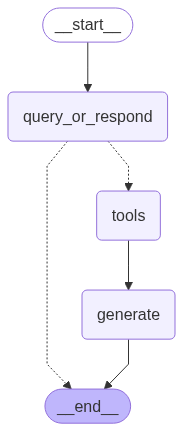

In [33]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
input_message = "Hello, is Reetu is a Customer name"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, is Reetu is a Customer name
================================== Ai Message ==================================
Tool Calls:
  retrieve (kp13f9mrw)
 Call ID: kp13f9mrw
  Args:
    query: Reetu
================================= Tool Message =================================
Name: retrieve

Source: {'invoice_id': '397373', 'date': '10 Sep 2024', 'reason': 'The reimbursement request is in compliance with the policy guidelines. The total amount of ₹233 is within the approved limits for travel expenses, and the invoice is supported by the required documentation.', 'employee_name': 'Reetu', 'status': 'accept'}
Content: Invoice Content: Original Tax Invoice Driver Trip Invoice Sunil Service Tax Category: Renting of Cab Cab 2F A1341 Invoice ID 397373 Invoice Date 10 Sep 2024 Customer Name Reetu Mobile Number 8901233212 Pickup Address Rajaji Nagar Descri`ption A mount (₹) Ride F ee ₹ 187.46 T oll Convenience f 